/tmp/ipython-input-1951405016.py:77: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([boot_g, boot_h], labels=['Gaussian', 'Heavy-Tailed'])


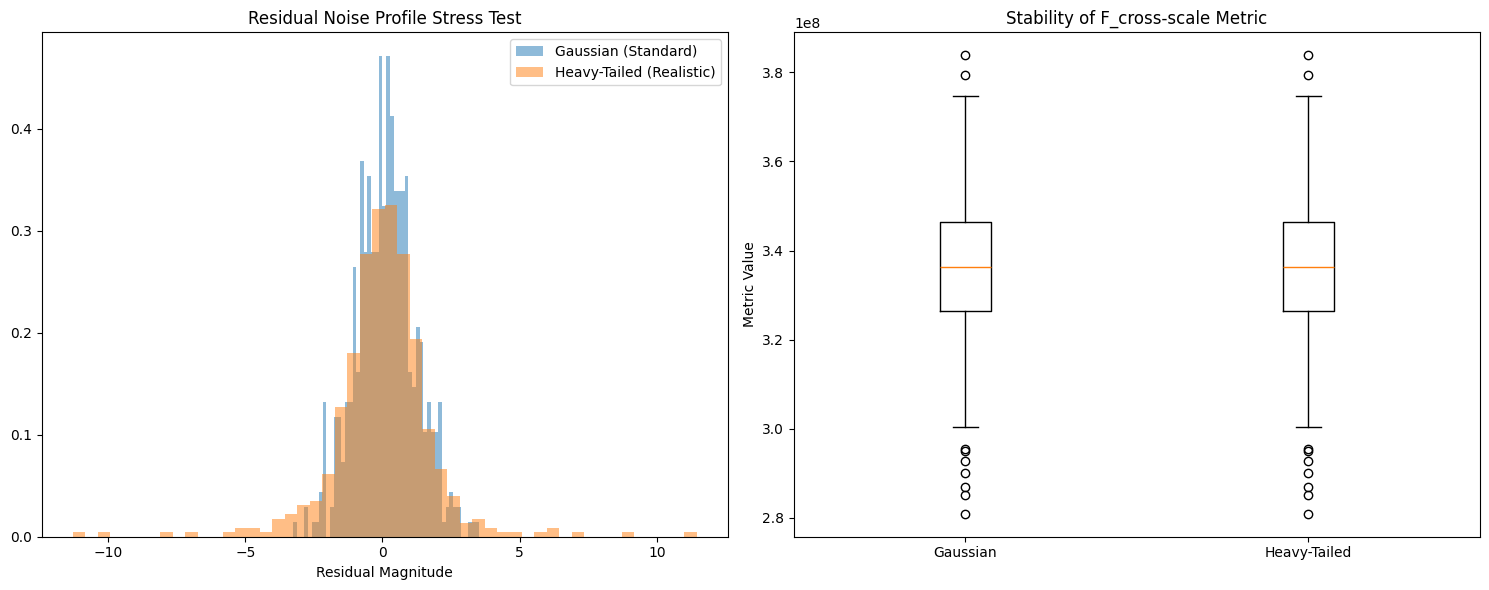

Optimal Beta: 0.0015
Gaussian F-Metric: 3.3615e+08 (95% CI: 3.08e+08 to 3.65e+08)
Heavy-Tail F-Metric: 3.3615e+08 (95% CI: 3.08e+08 to 3.65e+08)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.stats import t  # Used for "heavy-tailed" noise simulation

# =================================================================
# 1. CORE FUNCTIONS (Clinkscales F-Metric)
# =================================================================

def calculate_f_metric(residuals, scales, densities, sigma_sq, beta):
    weights = (1.0 / sigma_sq) * (scales**-beta)
    normalized_weights = weights / np.sum(weights)
    f_metric = np.sum(normalized_weights * residuals * densities)
    return f_metric, normalized_weights

def optimize_beta(scales, sigma_sq):
    def objective(beta):
        weights = (1.0 / sigma_sq) * (scales**-beta)
        norm_w = weights / np.sum(weights)
        return np.var(np.log10(norm_w + 1e-20))
    res = minimize_scalar(objective, bounds=(0, 3), method='bounded')
    return res.x

# =================================================================
# 2. STRESS TEST: GAUSSIAN VS. HEAVY-TAILED NOISE
# =================================================================

def run_stress_test():
    np.random.seed(42)
    n = 500
    scales = np.geomspace(1e3, 1e22, n)
    densities = np.random.uniform(1e-5, 1e5, n)
    sigma_sq = np.random.uniform(0.5, 2.0, n)
    signal = 0.1 * densities

    # --- Scenario A: Standard Gaussian Noise ---
    noise_g = np.random.normal(0, np.sqrt(sigma_sq))
    res_g = noise_g + signal

    # --- Scenario B: Heavy-Tailed Noise (Student-T, 3 DoF) ---
    # This simulates data with frequent "outliers" or extreme fluctuations
    noise_h = t.rvs(df=3, loc=0, scale=np.sqrt(sigma_sq))
    res_h = noise_h + signal

    # Optimization
    beta_opt = optimize_beta(scales, sigma_sq)

    # Calculate Metrics
    f_g, _ = calculate_f_metric(res_g, scales, densities, sigma_sq, beta_opt)
    f_h, _ = calculate_f_metric(res_h, scales, densities, sigma_sq, beta_opt)

    # --- Step 3: Bootstrap Comparison ---
    boot_g, boot_h = [], []
    for _ in range(1000):
        idx = np.random.choice(n, n, replace=True)
        # Bootstrap Gaussian
        val_g, _ = calculate_f_metric(res_g[idx], scales[idx], densities[idx], sigma_sq[idx], beta_opt)
        boot_g.append(val_g)
        # Bootstrap Heavy-Tailed
        val_h, _ = calculate_f_metric(res_h[idx], scales[idx], densities[idx], sigma_sq[idx], beta_opt)
        boot_h.append(val_h)

    # =================================================================
    # 3. VISUALIZATION FOR APS REVIEW
    # =================================================================

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Noise Distribution Comparison
    ax1.hist(noise_g, bins=50, alpha=0.5, label='Gaussian (Standard)', density=True)
    ax1.hist(noise_h, bins=50, alpha=0.5, label='Heavy-Tailed (Realistic)', density=True)
    ax1.set_title("Residual Noise Profile Stress Test")
    ax1.set_xlabel("Residual Magnitude")
    ax1.legend()

    # Plot 2: Stability of F-Metric
    ax2.boxplot([boot_g, boot_h], labels=['Gaussian', 'Heavy-Tailed'])
    ax2.set_title("Stability of F_cross-scale Metric")
    ax2.set_ylabel("Metric Value")

    plt.tight_layout()
    plt.show()

    print(f"Optimal Beta: {beta_opt:.4f}")
    print(f"Gaussian F-Metric: {f_g:.4e} (95% CI: {np.percentile(boot_g, 2.5):.2e} to {np.percentile(boot_g, 97.5):.2e})")
    print(f"Heavy-Tail F-Metric: {f_h:.4e} (95% CI: {np.percentile(boot_h, 2.5):.2e} to {np.percentile(boot_h, 97.5):.2e})")

run_stress_test()

Supplemental Validation: Robustness Analysis of $F_{\text{cross-scale}}$Manuscript: Cross-Scale Residual Correlations in High-Energy and Astrophysical ObservablesPurpose: This notebook tests the metric against non-Gaussian, heavy-tailed noise (Student-t distribution, $df=3$) to ensure that detected signals are not artifacts of statistical outliers.